In [1]:
import torch
import torch.nn as nn
from PIL import Image
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

import os
import math

import torch.nn.functional as F

In [2]:
PATH= Path("data\mnist")
PATH

WindowsPath('data/mnist')

In [3]:
kernel = np.array([-1,1])

In [4]:
def conv_batch(img, kernel):
    
    img = img.view(-1,28,28)
    out = torch.zeros(img.shape)
    
    for i in range(img.shape[0]):
        img_temp = np.pad(img[i],[(0, 0), (0, 1)],"edge")
        for j in range(img.shape[1]):

            for k in range(img.shape[2]-1):
                out[i][j][k] = abs((img_temp[j][k:k+2] * kernel).sum())
    
    return out.view(-1, 784)

In [5]:
def _get_files(p, fs, extensions = None):
    p = Path(p) # to support / notation
    res = [p/f for f in fs if not f.startswith(".") 
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [6]:
def log_softmax(x): 
    return (x.exp()/(x.exp().sum(-1,keepdim=True)) + 1e-20).log()

In [7]:
def nll(preds, actuals): 
    return -preds[range(actuals.shape[0]), actuals].mean()

In [8]:
def validation_acc(model):
    return torch.stack([accuracy(model(xb), yb) for xb, yb in valid_dl]).mean().item()

In [9]:
def accuracy(preds, yb): 
    return (torch.argmax(preds, dim=1, keepdim = True)==yb).float().mean()

In [10]:
def loss_func(preds, targets):
    preds = log_softmax(preds)
    return nll(preds, targets)

In [11]:
def train(model, train_dl, epochs=5, valid_epoch=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            
            preds = model(xb)
            loss = loss_func(preds, yb.squeeze())
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        if epoch % valid_epoch == 0:
            print(validation_acc(model))

In [12]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return conv_batch(self.x[i], kernel).cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

In [13]:
class Func(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)
    
def flatten(x):      
    return x.view(x.shape[0], -1)

def print_t(x):      
    print(x.shape)
    return x

# Question 1

In [24]:
def conv(img, kernel):
    
    out = np.zeros(img.shape)
    img = np.pad(img,[(0, 0), (0, 1)],"edge") # This will do the padding for not to reduce size
    
    for i in range(img.shape[0]):
    
        for j in range(img.shape[1]-1):
            out[i][j] = abs((img[i][j:j+2] * kernel).sum())
    
    return out

In [25]:
def create_ds_from_file(src):
    imgs, labels = [], []
    kernel = np.array([-1,1])
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            img = np.array(Image.open(e))
            l = [np.concatenate((conv(img, kernel).reshape(-1), img.reshape(-1)))]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [14]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

data\mnist\train\0
data\mnist\train\1
data\mnist\train\2
data\mnist\train\3
data\mnist\train\4
data\mnist\train\5
data\mnist\train\6
data\mnist\train\7
data\mnist\train\8
data\mnist\train\9


In [15]:
val_x,val_y = create_ds_from_file(PATH/"validation")

data\mnist\validation\0
data\mnist\validation\1
data\mnist\validation\2
data\mnist\validation\3
data\mnist\validation\4
data\mnist\validation\5
data\mnist\validation\6
data\mnist\validation\7
data\mnist\validation\8
data\mnist\validation\9


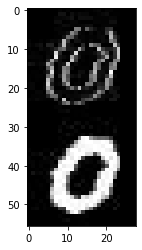

In [26]:
plt.imshow(trn_x[0].view(56,28),cmap="gray")

In [40]:
def normalize_data(x, y):
    x_divided = x.view(-1,784)
    x_mean = x_divided.mean(-1).view(-1,1)
    x_std = x_divided.std(-1).view(-1,1)
    x_norm = (x_divided-x_mean)/x_std
    
    return x_norm.view(-1,784*2),  y

In [41]:
trn_norm, trn_y = normalize_data(trn_x, trn_y)
val_norm, val_y = normalize_data(val_x, val_y)

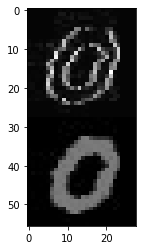

In [42]:
trn_norm.shape
plt.imshow(trn_norm[0].view(56,28),cmap="gray")

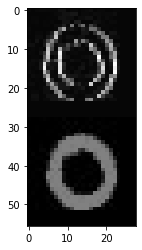

In [43]:
val_norm.shape
plt.imshow(val_norm[0].view(56,28), cmap="gray")

In [44]:
train_ds_norm = Dataset(trn_norm, trn_y)
valid_ds_norm = Dataset(val_norm,val_y)

train_dl_norm = DataLoader(train_ds_norm, 256)
valid_dl_norm = DataLoader(valid_ds_norm, 256)

In [45]:
trn_norm.shape

torch.Size([31216, 1568])

In [46]:
model = nn.Sequential(
    nn.Linear(56*28,60),
    nn.ReLU(),
    nn.Linear(60,10)
).cuda()

In [47]:
optim = torch.optim.SGD(model.parameters(), lr=0.01)

In [48]:
train(model, train_dl_norm,50,5)

RuntimeError: mat1 dim 1 must match mat2 dim 0

# Question 2

In [14]:
def create_ds_from_file(src):
    imgs, labels = [], []
    
    for label in range(10):
        path = src/str(label)
        print(path)
        t = [o.name for o in os.scandir(path)]
        t = _get_files(path, t, extensions = [".jpg", ".png"])
        for e in t:
            l = [np.array(Image.open(e)).reshape(28*28)]
            imgs += l
        labels += ([label] * len(t))
    return torch.tensor(imgs,  dtype=torch.float32), torch.tensor(labels, dtype=torch.long).view(-1,1)

In [15]:
trn_x, trn_y = create_ds_from_file(PATH/"train")

data\mnist\train\0
data\mnist\train\1
data\mnist\train\2
data\mnist\train\3
data\mnist\train\4
data\mnist\train\5
data\mnist\train\6
data\mnist\train\7
data\mnist\train\8
data\mnist\train\9


In [16]:
val_x,val_y = create_ds_from_file(PATH/"validation")

data\mnist\validation\0
data\mnist\validation\1
data\mnist\validation\2
data\mnist\validation\3
data\mnist\validation\4
data\mnist\validation\5
data\mnist\validation\6
data\mnist\validation\7
data\mnist\validation\8
data\mnist\validation\9


In [17]:
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self): 
        return len(self.x)
    def __getitem__(self, i): 
        return self.x[i].view(-1,1,28,28).cuda(),self.y[i].cuda()


class DataLoader():
    def __init__(self, ds, bs): 
        self.ds, self.bs = ds, bs
    def __iter__(self):
        n = len(self.ds)
        l = torch.randperm(n)

        
        for i in range(0, n, self.bs): 
            idxs_l = l[i:i+self.bs]
            yield self.ds[idxs_l]

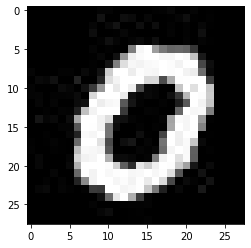

In [18]:
plt.imshow(trn_x[0].reshape(28,28), cmap="gray")

In [19]:
train_ds = Dataset(trn_x, trn_y)
valid_ds = Dataset(val_x,val_y)

In [20]:
train_dl = DataLoader(train_ds, 256)
valid_dl = DataLoader(valid_ds, 256)

In [21]:
model = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(), # 7
#         nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(), # 4
#         nn.Conv2d(32, 32, 3, padding=1,stride=2), nn.ReLU(), # 2
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(16,10)
).cuda()

In [22]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [24]:
train(model, train_dl,80,10)

0.3162245750427246
0.8225835561752319
0.905704915523529
0.9216024875640869
0.9277797937393188
0.9225109219551086
0.9311409592628479
0.9364098906517029


In [28]:
model1 = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=1,stride=1), nn.LeakyReLU(),
        nn.Conv2d(8, 16, 3, padding=1,stride=1), nn.LeakyReLU(),
        nn.Conv2d(16, 32, 3, padding=1,stride=1), nn.LeakyReLU(),
#         nn.Conv2d(32, 32, 3, padding=1,stride=2), nn.ReLU(),
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(32,10)
).cuda()

In [29]:
train(model1, train_dl,80,10)

0.10610464960336685
0.10546875
0.1041969507932663
0.1041969507932663
0.10610464960336685
0.10546875
0.10610464960336685
0.10737645626068115


In [34]:
model2 = nn.Sequential(
        nn.Conv2d(1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16, 32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32, 32, 3, padding=1,stride=2), nn.ReLU(), # 2
        #Func(print_t),
        nn.AdaptiveAvgPool2d(1),
        Func(flatten),
        nn.Linear(32,10)
).cuda()

In [35]:
train(model2, train_dl,80,10)

0.06277252733707428
0.06213662773370743
0.061500728130340576
0.06277252733707428
0.061500728130340576
0.06404433399438858
0.06277252733707428
0.06213662773370743


# Question 4

In [57]:
trial = torch.randint(low=-50, high=50, size=(25,1), dtype=torch.float)

In [58]:
def logsumexp(x):
    return torch.log(torch.exp(x).sum()) 

In [59]:
logsumexp(trial)

tensor(48.6967)

In [60]:
torch.logsumexp(trial, 0)

tensor([48.6967])

# Question 3

Stride-Adım olarak tanımlanmıştır.

Resimler üzerinde önemli bilgilerin çıkarılabilmesi için değişik kernel'ler kullanılır. Bu kernel'ler ile kenar bilgileri çıkarılabilir, blurlu resimler elde edilebilir veya resim kenarları belirginleştirilebilir. Bu kerneller verilen resimler üzerinde dolaştırılır ve filtrelenmiş resimler elde edilir. Filtrelenmiş resimler için kernellerin dolaştırılmadan önce padding işlemi yapılarak tüm piksellerin aynı miktar işlem görmesi sağlanmış olur. Adım sayısı kernelin resim üzerinde ilerletilmesi esnasında kernelin ne kadar aralıkla hareket ettirildiğini ifade etmektedir. Stride sayısı arttırıldığında filtrelenmiş resim boyutu azaltılmış olur. Stride ne kadar arttırılırsa dikkate alınan piksellerin her işlemde dikkate alınma sayısı azaltılmış olur.